In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay



In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'archive-3/train',
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'
)

val_generator = train_datagen.flow_from_directory(
    'archive-3/train',
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    'archive-3/test',
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1) ),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')

])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,783 (4.87 MB)

 Trainable params: 1,275,335 (4.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))





In [5]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    class_weight=class_weights 
)


Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.1712 - loss: 2.4201 - val_accuracy: 0.2303 - val_loss: 1.8630
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.2107 - loss: 1.8734 - val_accuracy: 0.2099 - val_loss: 1.8428
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.2416 - loss: 1.8316 - val_accuracy: 0.2075 - val_loss: 1.8399
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.2797 - loss: 1.7741 - val_accuracy: 0.2916 - val_loss: 1.7875
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.3019 - loss: 1.7114 - val_accuracy: 0.3435 - val_loss: 1.7188
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.3420 - loss: 1.6494 - val_accuracy: 0.2844 - val_loss: 1.7880
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.3532 - loss: 1.6484 - val_accuracy: 0.3856 - val_loss: 1.6087
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.3931 - loss: 1.5371 - val_accurac

In [6]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4514 - loss: 1.4556
Test Loss: 1.4359, Test Accuracy: 0.4611


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


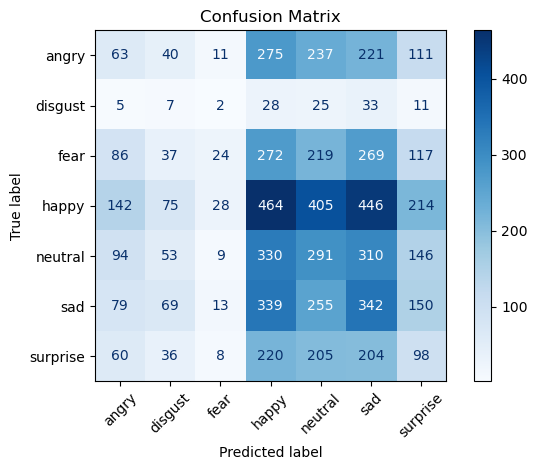

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [8]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

print("Precision (weighted):", precision_score(y_true, y_pred_classes, average='weighted'))
print("Recall (weighted):", recall_score(y_true, y_pred_classes, average='weighted'))
print("F1 Score (weighted):", f1_score(y_true, y_pred_classes, average='weighted'))



Classification Report:

              precision    recall  f1-score   support

       angry       0.12      0.07      0.08       958
     disgust       0.02      0.06      0.03       111
        fear       0.25      0.02      0.04      1024
       happy       0.24      0.26      0.25      1774
     neutral       0.18      0.24      0.20      1233
         sad       0.19      0.27      0.22      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.16      0.15      0.14      7178
weighted avg       0.19      0.18      0.17      7178

Precision (weighted): 0.18824056052886626
Recall (weighted): 0.17957648370019505
F1 Score (weighted): 0.16692450935366288


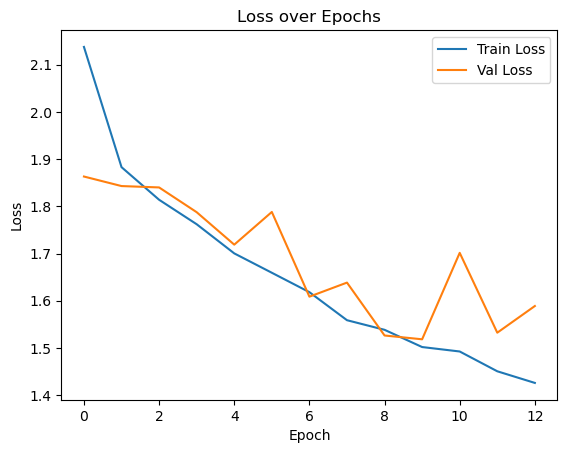

In [9]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

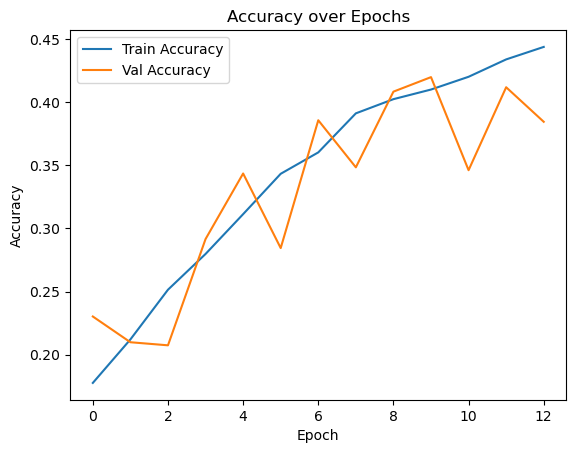

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


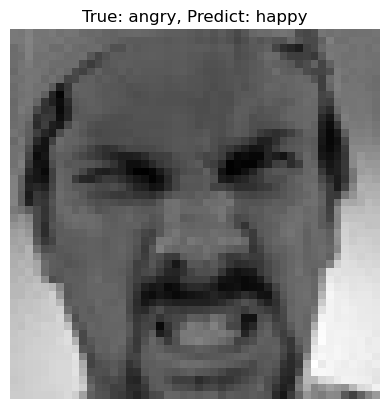

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


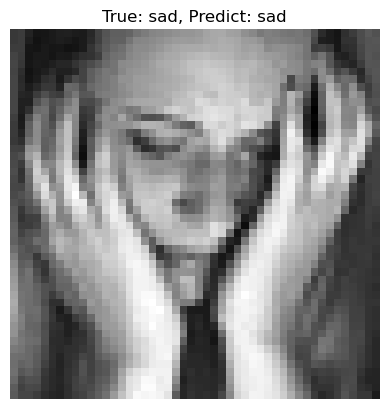

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


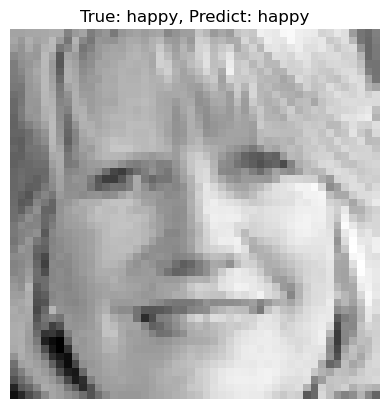

In [13]:
images, labels = test_generator[20]  
for i in range(3):
    image = images[i]
    true_label = np.argmax(labels[i])
    prediction = model.predict(np.expand_dims(image, axis=0))
    predicted_class = np.argmax(prediction)

    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True: {class_labels[true_label]}, Predict: {class_labels[predicted_class]}")
    plt.axis('off')
    plt.show()